## Imports

In [103]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

# Import crawling libraries
import pickle
#from src.crawler.crawler import *
%reload_ext autoreload
%autoreload 2

# Import clustering libraries (methods and metrics)
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from collections import defaultdict
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import silhouette_score

# Import NLP libraries
from nltk import sent_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')
import spacy

# For progress bar
from tqdm import tqdm

# To load data
from src import Helpers

# Levenshtein distance, to compare sequences
from Levenshtein import distance as leven_dist

# Statistical test
from scipy.stats import binomtest

## Loading and cleaning the data from the CMU database

## 2.3. Actor transition between movie types based on summaries

**But what if we want to be even more accurate to creat the transition matrix ?**

Well, we are currently running a NLP pipeline using BERT to transform summaries into vectors and extract useful informations.
Indeed, the summary of a movie seems more informative than genres or eigeingenres to describe a movie. We will see if it helps to explain the career path of our actors.

An example of the code ran to get those vectors is in the `./src/nlp_summaries.ipynb` notebook (it is not in this notebook because it takes a while to run).

In [104]:
movie = pd.read_pickle("./movie_with_ascending_genres.pkl")

In [105]:
# Preprocess the data
CHAR_PATH = "./data/full_characters_final"
nlp_data = pd.read_pickle(CHAR_PATH)
probabilities = nlp_data.iloc[-2]['Probabilities']

# Assuming your DataFrame is named df
df = nlp_data.dropna(subset=['Probabilities','Actor_age'])
print(df.shape)
desired_columns = ['Actor_name','MainCharType', 'Actor gender', 'Actor date of birth', 'Actor_age', 'Fb_actor_id', 'Wikipedia_movie_ID', 'Fb_movie_id', 'Probabilities']
df = df[desired_columns]
merged_data = pd.merge(df, movie[['Wikipedia_movie_ID', 'Movie_release_date','Movie_main_genres']], on='Wikipedia_movie_ID', how='left')

# Get rid of rows where 'Movie_main_genres' is NaN
merged_data.dropna(subset=['Movie_main_genres'],inplace=True)

# Add the Film_index colum
# Sort the DataFrame by 'Freebase_actor_ID', 'Actor_age', 'Character', and 'Movie_release_date'
merged_data.sort_values(["Fb_actor_id", "Actor_age", "Movie_release_date"], inplace=True)

# Calculate the i-th film for each actor based on major roles and movie release date
merged_data["Film_Index"] = (
    merged_data.groupby("Fb_actor_id")
    .cumcount() + 1  # Adding 1 to start indexing from 1 instead of 0
)

# Counting the number of films per actor
films_per_actor = merged_data['Actor_name'].value_counts()

# Adding a new column with the number of films each actor played in
merged_data['Num_films_played'] = merged_data['Actor_name'].map(films_per_actor)

# Group the data by actor name and sort by movie release date
grouped = merged_data.groupby('Actor_name').apply(lambda x: x.sort_values('Movie_release_date'))

grouped


(19107, 21)


Actor_name                    MainCharType  \
Actor_name                                                               
50 Cent         3258           50 Cent   Emotional and Romantic Tropes   
                17811          50 Cent      Occupation and Professions   
                13352          50 Cent   Emotional and Romantic Tropes   
A Martinez      17480       A Martinez          Adventurers and Heroes   
A. J. Bowen     10770      A. J. Bowen          Adventurers and Heroes   
...                                ...                             ...   
Zooey Deschanel 10685  Zooey Deschanel  Everyday Characters and Tropes   
                13404  Zooey Deschanel   Emotional and Romantic Tropes   
                17316  Zooey Deschanel          Stereotypes and Tropes   
Zulay Henao     13565      Zulay Henao  Everyday Characters and Tropes   
Željko Ivanek   14013    Željko Ivanek          Stereotypes and Tropes   

                      Actor gender Actor date of birth  Actor_age Fb_actor_id  \
Actor_name                                                                      
50 Cent         3258             M          1975-07-06       30.0     01vvyc_   
                17811            M          1975-07-06       31.0     01vvyc_   
                13352            M          1975-07-06       35.0     01vvyc_   
A Martinez      17480            M          1948-09-27       62.0     025rrt9   
A. J. Bowen     10770            M          1977-12-21       29.0     02x5mwj   
...                            ...                 ...        ...         ...   
Zooey Deschanel 10685            F          1980-01-17       28.0      03rl84   
                13404            F          1980-01-17       29.0      03rl84   
                17316            F          1980-01-17       31.0      03rl84   
Zulay Henao     13565            F          1979-05-29       29.0     05zn08c   
Željko Ivanek   14013            M          1957-08-15       27.0      08_rjc   

                       Wikipedia_movie_ID Fb_movie_id  \
Actor_name                                              
50 Cent         3258            2617126.0      07s114   
                17811           5867940.0      0f9x7r   
                13352          24150888.0     07k4g72   
A Martinez      17480          30231661.0     0g53l41   
A. J. Bowen     10770          12117643.0     02vqc77   
...                                   ...         ...   
Zooey Deschanel 10685          18953471.0     02vyyl8   
                13404          18057739.0     047msdk   
                17316          28173585.0     0cmbmct   
Zulay Henao     13565          21015620.0     05b2s45   
Željko Ivanek   14013          21777123.0     05mrntz   

                                                           Probabilities  \
Actor_name                                                                 
50 Cent         3258   {'Adventurers and Heroes': 0.0, 'Complex Perso...   
                17811  {'Adventurers and Heroes': 0.21752424494953299...   
                13352  {'Adventurers and Heroes': 0.0, 'Complex Perso...   
A Martinez      17480  {'Adventurers and Heroes': 0.31785584519605975...   
A. J. Bowen     10770  {'Adventurers and Heroes': 0.45972752528829336...   
...                                                                  ...   
Zooey Deschanel 10685  {'Adventurers and Heroes': 0.0, 'Complex Perso...   
                13404  {'Adventurers and Heroes': 0.0, 'Complex Perso...   
                17316  {'Adventurers and Heroes': 0.03874852565953268...   
Zulay Henao     13565  {'Adventurers and Heroes': 0.0, 'Complex Perso...   
Željko Ivanek   14013  {'Adventurers and Heroes': 0.0, 'Complex Perso...   

                             Movie_release_date  \
Actor_name                                        
50 Cent         3258  2005-11-09 00:00:00+00:00   
                17811 2006-12-15 00:00:00+00:00   
                13352 2010-08-05 00:00:00+00:00   
A Martinez      17480 201

For each actor, we encode its career in terms of genres played over time. If "a" is drama and "b" is comedy, then "aab" means that the first two movies of the actor are dramas and his last one is a comedy. This way, we get a sequence for each actor. 

However, to make this sequence more representative of the overall trends in an actor's career (in order to achieve a better clustering, see below), we encode the career by using some sort of "moving average" : we look at the first three movies, gather all the genres they represent, calculate a score for each genre and select the one genre that is most represented (i.e. has the highest score). Then we look at the next triplet of movies, and repeat the procedure.

To prevent a tie between two genres, we actually compute a score with weightings : for instance, if Drama is present in movie n°1, then the score for Drama over the first triplet of movies is increased by 1 x Weights[Drama].

Weight for each genre corresponds to the inverse of the square root of its occurences in the whole dataset (to correct imbalances in terms of genre : for instance, Drama is very present in the dataset, so it should not count as much as others when it appears in the genres list of a movie)

In [106]:
# We only keep actors with at least 5 movies to their records
grouped_filtered = grouped[grouped['Num_films_played']>=5]

In [107]:
# Compute the proportion of women in the dataset
proportion_of_women = len(grouped_filtered[grouped_filtered["Actor gender"] == 'F']) / len(grouped_filtered)
print("The proportion of women in the dataset is : {:2.2%}".format(proportion_of_women))

The proportion of women in the dataset is : 32.66%


In [108]:
# Weight by genre
weights = {}
# Calculate number of occurences of each genre in the entire dataset
genres_occurences = Counter(grouped_filtered.Movie_main_genres.sum())
# Compute weight for each genre (inverse of the square root number of occurences)
for _, (genre,nb_occ) in enumerate(genres_occurences.items()):
    weights[genre] = 1 / np.sqrt(nb_occ)
# Normalization
tot = sum(weights.values())
for _, (genre, weight) in enumerate(weights.items()):
    weights[genre] = weight / tot

print(weights)

{'Thriller': 0.05141464413218506, 'Drama': 0.04461503642625903, 'SF/Horror': 0.06454399924975307, 'Action': 0.05352279123174404, 'Sports': 0.13866458202525445, 'History': 0.06719968497985929, 'BW/Silent': 0.08639664653466925, 'Comedy': 0.05090233029632652, 'Romance': 0.06287415399821403, 'Family': 0.07248301829177654, 'Culture': 0.15451306050942645, 'Musical': 0.15287005232453243}


In [109]:
# We use letters to encode career in terms of genre, because we have 12 genres and only 10 digits available (0,1,...,9)
genres_encoding_dic = {
    'Drama': 'a', 'Comedy': 'b', 'Thriller': 'c', 'Action': 'd', 'Family': 'e', 'SF/Horror': 'f', 'Romance': 'g', 
    'BW/Silent': 'h', 'History': 'i', 'Culture': 'j', 'Musical': 'k', 'Sports': 'l'
}

def encode_career_genres(df):
    
    actors_summary = []

    for actor, actor_group in df.groupby(level=0):
        
        nb_films_played = actor_group['Num_films_played'].values[0]
        
        actor_summary = {
            'Actor_name': actor,
            'Gender' : actor_group['Actor gender'].values[0],
            'Num_films_played_with_known_genres': nb_films_played,
            'Fb_actor_ID': actor_group['Fb_actor_id'].values[0],
        }
        
        career_code = ''
        
        if nb_films_played > 2:
        # We encode one character for each triplet of consecutive movies in the actor's career
            for i in range(nb_films_played - 2):
                genres_played_over_three_movies = []
                # Add genres of previous movie
                genres_played_over_three_movies.extend(actor_group['Movie_main_genres'].values[i])
                # Add genres of following movie
                genres_played_over_three_movies.extend(actor_group['Movie_main_genres'].values[i+1])
                # Add genres of following movie of the previous one
                genres_played_over_three_movies.extend(actor_group['Movie_main_genres'].values[i+2])
                # Use the Counter subclass to count occurences of each genre in the list
                occ_by_genre = Counter(genres_played_over_three_movies)
                score_by_genre = {}
                # Use weights
                for _, (genre,score) in enumerate(occ_by_genre.items()):
                    score_by_genre[genre] = score * weights[genre]
                # Get dominant genre
                dominant_genre = max(score_by_genre, key=score_by_genre.get)
                career_code += genres_encoding_dic.get(dominant_genre, '0')
                
                
        else: # Actor has played in only one movie
            career_code = genres_encoding_dict.get(actor_group.iloc[0, 'Movie_main_genres'][0], '0')
            
        actor_summary['Career_code'] = career_code
            
        actors_summary.append(actor_summary)

    summary_df = pd.DataFrame(actors_summary)
    
    return summary_df

# Encode careers in terms of genre for all actors
copy = grouped_filtered.copy(deep=True)
summary_df = encode_career_genres(copy)
summary_df.set_index(['Fb_actor_ID'], inplace=True)
summary_df

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code
Fb_actor_ID,,,,
03t4cz,Aaron Eckhart,M,12,cflfiiiaaa
02rb9_g,Aaron Johnson,M,6,hhdd
07r_dg,Abigail Breslin,F,8,hhhgaf
038nv6,Adam Baldwin,M,6,ddde
03jqw5,Adam Goldberg,M,5,ejj
...,...,...,...,...
06wm0z,Zac Efron,M,10,kkkkgikk
02_0d2,Zach Galifianakis,M,10,bbbbbbbb
02q2vzj,Zachary Gordon,M,7,eeeee


### Compare these careers with Levenshtein distance

In [8]:
# Example
weights = (1,1,1) #(insertion, deletion, substitution) weights : here, we penalize substitutions
# Note : these weights are used for the objective function of the Lev distance,
# but the method keeps returning a number of operations (not a weighted number)
leven_dist('levenshtein', 'alewensstein', weights=(1,1,1))

3

In [9]:
# Compute the distances in careers between all actors
precomputed_dist = pd.DataFrame(index=summary_df.index, columns=summary_df.index)

for actor in tqdm(summary_df.index):
    for other_actor in summary_df.index:
        if other_actor == actor:
            precomputed_dist.at[actor,other_actor] = 0
        else:
            precomputed_dist.at[actor,other_actor] = leven_dist(summary_df.loc[actor, 'Career_code'],
                                                                 summary_df.loc[other_actor, 'Career_code'],
                                                                weights = (1,1,1))
            
precomputed_dist

100%|██████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:29<00:00, 36.31it/s]


Fb_actor_ID,03t4cz,02rb9_g,07r_dg,038nv6,03jqw5,0pz91,06c_41,01cj6y,045c66,0bj9k,...,086sj,081lh,0170s4,021hp8,0gqrb,06wm0z,02_0d2,02q2vzj,05qg6g,03rl84
Fb_actor_ID,,,,,,,,,,,,,,,,,,,,,
03t4cz,0,10,9,10,10,22,10,10,6,13,...,16,10,17,10,10,9,10,10,10,10
02rb9_g,10,0,4,3,4,23,4,6,9,18,...,18,4,17,3,2,8,8,5,3,7
07r_dg,9,4,0,6,6,22,6,5,9,17,...,16,4,16,6,6,7,8,6,6,6
038nv6,10,3,6,0,4,23,4,7,10,18,...,19,6,19,2,2,8,8,4,2,9
03jqw5,10,4,6,4,0,23,2,7,10,16,...,17,6,17,2,4,8,8,4,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06wm0z,9,8,7,8,8,17,8,6,10,17,...,18,8,19,8,7,0,8,8,8,9
02_0d2,10,8,8,8,8,15,7,8,10,18,...,17,8,13,8,8,8,0,8,8,5
02q2vzj,10,5,6,4,4,23,5,7,10,18,...,19,6,19,5,5,8,8,0,5,9


In [10]:
# We define a cost function (distance from each point to its assigned medoid) to choose the best number of clusters

def total_cost(centers, clusters, distance_matrix):
    cost=0
    for index, cluster in enumerate(clusters):
        center = centers[index]
        for point in cluster:
            cost += distance_matrix[center,point]
    return(cost)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:25<00:00,  7.80s/it]


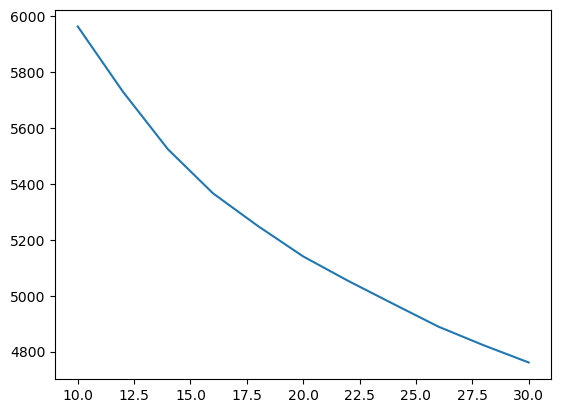

In [11]:
# Find the best number of clusters
distance_matrix = precomputed_dist.to_numpy().astype(float)
res = []
nb_iter = 3
k_tested = range(10,31,2)

for k in tqdm(k_tested):
    res_k = 0
    # Perform the clustering 3 times, as solutions found depend on intialization
    for _ in range(nb_iter):
        # Set k random initial medoids
        initial_medoids = np.random.randint(len(distance_matrix), size=k)
        kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type = 'distance_matrix')
        # Run cluster analysis and obtain results
        kmedoids_instance.process()
        clusters = kmedoids_instance.get_clusters()
        centers = kmedoids_instance.get_medoids()
        # Compute total cost
        res_k += total_cost(centers, clusters, distance_matrix)
        # Assign label (medoid actor) to each actor
        #actor_to_cluster = ['' for _ in range(len(summary_df.index))]
        #for index, cluster in enumerate(clusters):
        #    medoid = centers[index]
        #    medoid_actor = summary_df.iloc[medoid]['Actor_name']
        #    for point in cluster:
        #        actor_to_cluster[point] = medoid_actor
        # Compute silhouette score
        #slt =  silhouette_score(distance_matrix, actor_to_cluster, metric='precomputed')
        #if slt > res_k:
        #    res_k = slt
    res.append(res_k/nb_iter)
    
plt.plot(k_tested, res)

The elbow technique won't be really useful here... But we have 12 genres so let's choose k higher than this number to be able to differentiate between career paths (otherwise, each cluster will most likely correspond to one dominating genre in a career) !
Let's try k = 20

# Note : don't run the following pieces of code again (as k-medoids will give slightly different results each time it is run)

In [15]:
k = 20
distance_matrix = precomputed_dist.to_numpy().astype(float)

# Set random initial medoids.
initial_medoids = np.random.randint(len(distance_matrix), size=k)
kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type = 'distance_matrix')
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
centers = kmedoids_instance.get_medoids()

print(centers)
for c in clusters:
    print(len(c))
print(total_cost(centers, clusters, distance_matrix))

[218, 462, 173, 36, 454, 127, 228, 424, 445, 83, 716, 159, 879, 436, 22, 33, 95, 113, 64, 184]
48
78
80
24
37
76
99
41
52
7
1
113
67
32
45
68
43
69
54
42
5140.0


In [16]:
# Assign cluster (medoid actor) to each actor
actor_to_cluster = ['' for _ in range(len(summary_df.index))]

for index, cluster in enumerate(clusters):
    medoid = centers[index]
    medoid_actor = summary_df.iloc[medoid]['Actor_name']
    for point in cluster:
        actor_to_cluster[point] = medoid_actor
        
summary_df['Cluster'] = actor_to_cluster
summary_df

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster
Fb_actor_ID,,,,,
03t4cz,Aaron Eckhart,M,12,cflfiiiaaa,Jean Simmons
02rb9_g,Aaron Johnson,M,6,hhdd,Bruce Boxleitner
07r_dg,Abigail Breslin,F,8,hhhgaf,Clara Bow
038nv6,Adam Baldwin,M,6,ddde,Bruce Boxleitner
03jqw5,Adam Goldberg,M,5,ejj,Chris Penn
...,...,...,...,...,...
06wm0z,Zac Efron,M,10,kkkkgikk,Danny Kaye
02_0d2,Zach Galifianakis,M,10,bbbbbbbb,Billy Crystal
02q2vzj,Zachary Gordon,M,7,eeeee,Christopher Lloyd


In [17]:
summary_df.Cluster.value_counts()

Cluster
Chris Penn           113
David Morse           99
Christopher Lloyd     80
Jean Simmons          78
Carl Weathers         76
Bruce Boxleitner      69
Amy Yasbeck           68
Robert Patrick        67
Ashley Greene         54
Jason Biggs           52
Danny Kaye            48
Alison Lohman         45
Billy Crystal         43
Clara Bow             42
James Franco          41
Jason Statham         37
Jamie Lee Curtis      32
Andy García           24
Bette Davis            7
Mel Blanc              1
Name: count, dtype: int64

Unfortunately, clusters incorporate a lot of 'noise' (actors that should not particularly be there) that disturb the interpretation of clusters.

For each cluster, we calculate the distance of each actor to the medoid actor, calculate the median value for this distance, and discard actors that have a distance above it.

In [18]:
medoids_actors = summary_df.Cluster.unique()
dico_clusters = {}

for medoid_actor_name in medoids_actors:
    # Get the cluster related to the medoid actor
    tmp_cluster = summary_df[summary_df.Cluster == medoid_actor_name].copy()
    # Get its career code
    medoid_career_code = summary_df[summary_df.Actor_name == medoid_actor_name].iloc[0]['Career_code']
    # For each actor in the cluster, compute its distance to the medoid actor
    tmp_cluster['distance_to_medoid'] = tmp_cluster.Career_code.apply(lambda x : 
                                                                      leven_dist(x, medoid_career_code, weights = (1,1,1)))
    # Compute the median distance value
    median_distance = tmp_cluster.distance_to_medoid.median()
    # Keep only actors below this median value
    filtered_tmp_cluster = tmp_cluster[tmp_cluster.distance_to_medoid <= median_distance]
    # Store the result
    dico_clusters[medoid_actor_name] = filtered_tmp_cluster.copy()

In [19]:
for _, (medoid_actor,related_cluster) in enumerate(dico_clusters.items()):
    print('Cluster '+medoid_actor+ " : "+str(len(related_cluster)))

Cluster Jean Simmons : 47
Cluster Bruce Boxleitner : 48
Cluster Clara Bow : 25
Cluster Chris Penn : 61
Cluster Billy Crystal : 25
Cluster David Morse : 64
Cluster Jamie Lee Curtis : 20
Cluster Danny Kaye : 25
Cluster Christopher Lloyd : 47
Cluster Jason Biggs : 26
Cluster Alison Lohman : 30
Cluster Ashley Greene : 35
Cluster Carl Weathers : 46
Cluster Amy Yasbeck : 53
Cluster Andy García : 15
Cluster Robert Patrick : 55
Cluster Jason Statham : 20
Cluster James Franco : 21
Cluster Bette Davis : 4
Cluster Mel Blanc : 1


In [21]:
# Save the results
with open('Levenshtein_clusters_final.pickle', 'wb') as handle:
    pickle.dump(dico_clusters, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Recall our genre encoding
genres_encoding_dic = {
    'Drama': 'a', 'Comedy': 'b', 'Thriller': 'c', 'Action': 'd', 'Family': 'e', 'SF/Horror': 'f', 'Romance': 'g', 
    'BW/Silent': 'h', 'History': 'i', 'Culture': 'j', 'Musical': 'k', 'Sports': 'l'
}

We have 20 clusters. Let's show below the most significant ones and explain them, using the genre encoding shown just above.

In [23]:
# Load the results (if needed)
with open('Levenshtein_clusters_final.pickle', 'rb') as handle:
    dico_clusters_final = pickle.load(handle)

---
Cluster **Bette Davis** (4 actors)

Most famous actors from classical Hollywood era :  many Black and White movies, extremely long career

In [24]:
dico_clusters_final['Bette Davis']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
0bw6y,Barbara Stanwyck,F,35,hhhhhhhhhhhhhgghhhhahcccccchhhdac,Bette Davis,11
0h1m9,Bette Davis,F,37,hhhhhhhhhhhhhhgihhhhhhhhaaahhhhaafc,Bette Davis,0
0c2tf,Gary Cooper,M,36,dghhhhhggghhhhhhhhhhhhhhhaiaiiiadd,Bette Davis,15
0cgbf,Joan Crawford,F,36,hhhhhhhhhhhhhhhhhhhhhhhhhhhhhkkhhh,Bette Davis,10


---
Cluster **James Franco** (21 actors)

Quite a long career, with some history/biopic movies at the beginning, then mostly action movies.

In [26]:
dico_clusters_final['James Franco']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
0b_fw,Anthony Quinn,M,13,hhhadddiiid,James Franco,7
01s7zw,Bill Paxton,M,12,jdddddllcf,James Franco,7
01mqc_,Christian Slater,M,13,eiidddcccdf,James Franco,5
03v3xp,Clive Owen,M,12,ciiiacdddc,James Franco,4
03ds3,Gary Busey,M,12,kdcdddlldd,James Franco,5
038rzr,Gerard Butler,M,11,ffkaggcdd,James Franco,7
0184jc,Guy Pearce,M,13,cciicchaddd,James Franco,6
0237fw,Heath Ledger,M,13,iiiiillidkk,James Franco,7
05bnp0,James Franco,M,11,iiidddddd,James Franco,0


---
Cluster **Jason Statham** (20 actors)

Long career, with many action movies.

In [45]:
dico_clusters_final['Jason Statham']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
0f4vbz,Angelina Jolie,F,17,jacclllldjjjdcd,Jason Statham,11
0tc7,Arnold Schwarzenegger,M,24,llfdhdddddfdddddbdffdd,Jason Statham,11
01fh9,Billy Bob Thornton,M,16,lllbagjjjadbbd,Jason Statham,9
0187y5,Burt Reynolds,M,21,llbbbbbbdglbdddkkll,Jason Statham,12
01pllx,Charlie Sheen,M,21,lldalllddddidddddbb,Jason Statham,7
0205dx,Danny Glover,M,16,ddddddljjjiiaa,Jason Statham,10
01f6zc,Gary Oldman,M,21,jjjkkkddkkcdddddffc,Jason Statham,12
03h_9lg,Hugh Jackman,M,15,ffffffffffddd,Jason Statham,10
034hyc,Jason Statham,M,15,lllddddlddddd,Jason Statham,0


---
Cluster **Robert Patrick** (55)

Small career, most roles obtained in musicals.

In [47]:
dico_clusters_final['Robert Patrick']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
04066xj,Anna Kendrick,F,5,hbk,Robert Patrick,2
06tp4h,Ashley Tisdale,F,6,kkke,Robert Patrick,1
01mpq7s,Beyoncé,F,5,kkk,Robert Patrick,0
05pmzb,Brenda Song,F,5,ekd,Robert Patrick,2
01yfm8,Bruce Greenwood,M,7,jjkkk,Robert Patrick,2
01_2bb,Candace Cameron-Bure,F,5,kki,Robert Patrick,1
02__7n,Christine Baranski,F,5,ggk,Robert Patrick,2
02stwg,Donnie Wahlberg,M,6,kkjf,Robert Patrick,2
032nl2,Drake Bell,M,5,iek,Robert Patrick,2


---
Cluster **Andy García** (15)

Long and quite heterogeneous/diverse careers, made of several periods spent in one particular genre. Prevalence of dramas and thrillers.

In [50]:
dico_clusters_final['Andy García']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
01yhd1,Andy García,M,19,cccccaacccccaaaca,Andy García,0
0z4s,Anthony Hopkins,M,27,jjaccfiiiiiiiaaaiicccaacf,Andy García,16
0151w_,Ben Affleck,M,21,ghhdkaaicdccllggaac,Andy García,12
0pmhf,Denzel Washington,M,25,kkkaiiiicccccccaaaccccd,Andy García,14
017149,Ed Harris,M,21,jjjjcccaagiiaaaccdi,Andy García,12
039bp,Gene Hackman,M,25,aaaefddaldcccccddljjjcc,Andy García,16
09fb5,Jack Nicholson,M,26,akccaaiiiiiicjjjcccabbll,Andy García,16
043js,James Spader,M,18,eeeggaaaaccchhcd,Andy García,11
04954,Kevin Bacon,M,23,kabbddiidcccccccahhhd,Andy García,15


---
Cluster **Amy Yasbeck** (53)

Small career, based on comedy movies.

In [51]:
dico_clusters_final['Amy Yasbeck']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
03ds83,Amy Smart,F,6,bbbg,Amy Yasbeck,1
05xh50,Amy Yasbeck,F,5,bbb,Amy Yasbeck,0
07ymr5,Andy Samberg,M,5,dbb,Amy Yasbeck,1
01dw9z,Bette Midler,F,7,bbbbb,Amy Yasbeck,2
033_1p,Beverly D'Angelo,F,5,bbb,Amy Yasbeck,0
01_xtx,Bradley Cooper,M,7,bbbcb,Amy Yasbeck,2
0p_jc,Chevy Chase,M,7,jjbbb,Amy Yasbeck,2
0qdgc,Christine Taylor,F,5,bbl,Amy Yasbeck,1
015c2f,Cynthia Nixon,F,5,bbb,Amy Yasbeck,0


---
Cluster **Carl Weathers** (46)

Rather short career, with a lot of sport movies (often martial arts movies).

In [56]:
dico_clusters_final['Carl Weathers']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
02jsrt,Amber Tamblyn,F,8,lllhhc,Carl Weathers,3
028pzq,Asia Argento,F,6,lhlj,Carl Weathers,2
0234pg,Carl Weathers,M,6,llll,Carl Weathers,0
0m9v7,Chow Yun-Fat,M,7,dllll,Carl Weathers,1
026rm_y,Christoph Waltz,M,6,dllg,Carl Weathers,2
077596,Ciarán Hinds,M,7,llljc,Carl Weathers,2
01x72k,Claire Forlani,F,7,gglll,Carl Weathers,2
016yvw,Daniel Day-Lewis,M,8,illlik,Carl Weathers,3
02v60l,David Arquette,M,7,llbdf,Carl Weathers,3


---
Cluster **Ashley Greene** (35)

Rather short career, with a lot of SF/horror/fantasy movies.

In [59]:
dico_clusters_final['Ashley Greene']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
0bzzf,Andie MacDowell,F,5,afg,Ashley Greene,2
03w9v1d,Ashley Greene,F,5,fff,Ashley Greene,0
06n3md,Camilla Belle,F,6,ffff,Ashley Greene,1
01tnbn,Carrie Fisher,F,5,eff,Ashley Greene,1
04jnqj,Chris Hemsworth,M,6,dfff,Ashley Greene,1
02fqwb,Cillian Murphy,M,6,cdff,Ashley Greene,2
01rr9f,Courteney Cox,F,6,ffhh,Ashley Greene,2
069ld1,Desmond Harrington,M,6,ffcf,Ashley Greene,1
07h046,Dominic Purcell,M,6,ffdc,Ashley Greene,2


---
Cluster **Alison Lohman** (30)

Rather small career, mostly based on history/biopic movies.

In [63]:
dico_clusters_final['Alison Lohman']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
053wg3,Alison Lohman,F,5,iii,Alison Lohman,0
0241jw,Andy Serkis,M,7,diiid,Alison Lohman,2
01w0qy2,Anne Archer,F,5,cid,Alison Lohman,2
03y9941,Armie Hammer,M,7,ffiii,Alison Lohman,2
07wcvr,Chase Ellison,M,5,iee,Alison Lohman,2
03s_zp,Cheryl Ladd,F,5,aai,Alison Lohman,2
02cbs0,Christopher Eccleston,M,5,iif,Alison Lohman,1
0j436,Esai Morales,M,5,iii,Alison Lohman,0
03s_y5,Gabrielle Anwar,F,5,icd,Alison Lohman,2


---
Cluster **Jason Biggs** (26)

Average/long career, mostly based on romances.

In [65]:
dico_clusters_final['Jason Biggs']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
01cwkq,Amanda Bynes,F,6,eggg,Jason Biggs,3
0338ws,Annabella Sciorra,F,5,ggg,Jason Biggs,3
0dqcm,Audrey Hepburn,F,6,gggk,Jason Biggs,3
03f1zdw,Colin Firth,M,11,giggggggg,Jason Biggs,3
01k5zk,Debra Winger,F,5,ggg,Jason Biggs,3
0cj2w,Dudley Moore,M,10,ggggggbk,Jason Biggs,2
018sgr,Gene Tierney,F,11,aggggghhh,Jason Biggs,4
02cj_f,George Sanders,M,7,gggik,Jason Biggs,3
016vg8,Heather Graham,F,11,ddbgggggg,Jason Biggs,3


---
Cluster **Christopher Lloyd** (47)

Career of average length, with a lot of family/teenager movies.

In [67]:
dico_clusters_final['Christopher Lloyd']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
0153vt,Alex D. Linz,M,10,geeeaeee,Christopher Lloyd,3
03bwz28,Ashley Olsen,F,8,eeeeed,Christopher Lloyd,1
015pvh,Bonnie Hunt,F,6,beee,Christopher Lloyd,2
03nb5v,Breckin Meyer,M,7,jbeeb,Christopher Lloyd,3
0bmn4p,Chad Michael Murray,M,5,eee,Christopher Lloyd,2
0ckv0t,Chiara Zanni,F,5,eee,Christopher Lloyd,2
0f0kz,Christopher Lee,M,9,eeefffe,Christopher Lloyd,3
01l_yg,Christopher Lloyd,M,7,eeeee,Christopher Lloyd,0
02l3_5,Cloris Leachman,F,9,bbeeebe,Christopher Lloyd,3


---
Cluster **Danny Kaye** (25)

Long career in musicals.

In [70]:
dico_clusters_final['Danny Kaye']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
01cwcr,Alan Cumming,M,12,dkkkkkkffe,Danny Kaye,4
03359d,Ali Larter,F,9,jjkkkcc,Danny Kaye,4
0b25vg,Amy Adams,F,11,khkiiibkk,Danny Kaye,5
0161h5,Angela Lansbury,F,10,kkkkkkkk,Danny Kaye,1
03f2_rc,Barbra Streisand,F,8,kkkkgg,Danny Kaye,3
02cllz,Bill Nighy,M,10,fffkkkdd,Danny Kaye,5
0c63ld,Cam Gigandet,M,9,efckkkc,Danny Kaye,4
013knm,Catherine Zeta-Jones,F,11,agkkkddkk,Danny Kaye,4
02h48,Danny Kaye,M,9,kkkkkkk,Danny Kaye,0


---
Cluster **Jamie Lee Curtis** (20)

Very long career, difficult to resume to one particular genre, but with many cult movies in it.

In [73]:
dico_clusters_final['Jamie Lee Curtis']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
0bj9k,Al Pacino,M,20,jjjccciiajjjlaaccc,Jamie Lee Curtis,11
018ygt,Alec Baldwin,M,18,jjccdffeekklbbbg,Jamie Lee Curtis,11
0p_pd,Bill Murray,M,20,jbbbbjjjbbbjjjhjjc,Jamie Lee Curtis,11
01l9p,Charlize Theron,F,17,fccaaaaaijjjfba,Jamie Lee Curtis,11
0bq2g,Gwyneth Paltrow,F,18,iiiigcggjjjfaakk,Jamie Lee Curtis,11
01vsn38,Jack Black,M,18,gbkjjjejjjbbbbbe,Jamie Lee Curtis,8
040z9,Jack Lemmon,M,13,hhgggaccbbb,Jamie Lee Curtis,7
0hwqz,Jamie Lee Curtis,F,13,jjjgcjjjbbb,Jamie Lee Curtis,0
02g0mx,Juliette Lewis,F,13,aaaccjjjjjh,Jamie Lee Curtis,7


---
Cluster **David Morse** (64)

Rather short career, mostly based on thrillers.

In [75]:
dico_clusters_final['David Morse']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
01cj6y,Adrien Brody,M,9,hkcgccc,David Morse,3
03m8lq,Amanda Peet,F,9,ccccjjj,David Morse,3
03sysz,Angie Harmon,F,5,egc,David Morse,3
01vhb0,Anne Heche,F,7,gccce,David Morse,2
016dgz,Anthony Perkins,M,9,gggcccc,David Morse,3
...,...,...,...,...,...,...
02661h,Tony Shalhoub,M,6,idcf,David Morse,3
01kmzs,Vincent Cassel,M,5,ccc,David Morse,1
050zr4,Virginia Madsen,F,6,jcdc,David Morse,2


---
Cluster **Billy Crystal** (25)

Ver long career, with a lot of comedy movies.

In [79]:
dico_clusters_final['Billy Crystal']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
013cr,Albert Brooks,M,10,bbbbbbbd,Billy Crystal,2
01pk3z,Anna Faris,F,14,fffbbbbbbbbb,Billy Crystal,3
01p4vl,Ashton Kutcher,M,11,bbbaddbgg,Billy Crystal,5
01h1b,Billy Crystal,M,11,bbbbbbbbb,Billy Crystal,0
016_mj,Chris Rock,M,15,lllbffdbbbbbb,Billy Crystal,6
0d608,Dan Aykroyd,M,17,jbdbbbbbbbkkklb,Billy Crystal,6
01vb403,Dick Van Dyke,M,11,kkkkbbbbb,Billy Crystal,4
0716t2,Elizabeth Banks,F,13,lbbbblllbca,Billy Crystal,6
027l0b,Gene Wilder,M,10,kkbbbbbb,Billy Crystal,3


---
Cluster **Chris Penn** (61)

Rather short career, but with some cult movies in it.

In [81]:
dico_clusters_final['Chris Penn']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
03jqw5,Adam Goldberg,M,5,ejj,Chris Penn,1
06c_41,Adam Scott,M,6,jjjb,Chris Penn,1
0563z6,Amber Valletta,F,5,ljj,Chris Penn,1
03xkps,Beau Bridges,M,5,jhd,Chris Penn,2
02lj6p,Bernie Mac,M,6,jjbk,Chris Penn,2
...,...,...,...,...,...,...
07lplr,Scout Taylor-Compton,F,6,ijjj,Chris Penn,1
02mkkx,Stellan Skarsgård,M,7,djjjk,Chris Penn,2
01twmp,Tommy Chong,M,5,jjj,Chris Penn,0


---
Cluster **Clara Bow** (25)

Actor from the classical Hollywood era (B&W movies), but with a shorter career than actors from the 'Bette Davis' cluster

In [85]:
dico_clusters_final['Clara Bow']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
07r_dg,Abigail Breslin,F,8,hhhgaf,Clara Bow,3
0jmj,Alan Alda,M,8,cbhhhj,Clara Bow,3
0qksf,Clara Bow,F,7,hhhhh,Clara Bow,0
04b8hz,Colin Hanks,M,7,khhhb,Clara Bow,2
01yhvv,Elisha Cuthbert,F,6,ehhh,Clara Bow,2
049g_xj,Ellen Page,F,6,hhhh,Clara Bow,1
03_vx9,Evan Rachel Wood,F,9,ghhhkhk,Clara Bow,3
06151l,Freddy Rodriguez,M,5,hhh,Clara Bow,2
0h14h,Greta Garbo,F,11,hhhhhhhhh,Clara Bow,4


---
Cluster **Bruce Boxleitner** (48)

Rather short career, mostly based on action movies.

In [87]:
dico_clusters_final['Bruce Boxleitner']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
02rb9_g,Aaron Johnson,M,6,hhdd,Bruce Boxleitner,2
038nv6,Adam Baldwin,M,6,ddde,Bruce Boxleitner,1
025z93,Bruce Boxleitner,M,5,ddd,Bruce Boxleitner,0
05fnl9,Bryan Cranston,M,6,kded,Bruce Boxleitner,2
01900g,Chris Tucker,M,7,jdddl,Bruce Boxleitner,2
02hg53,Chuck Connors,M,6,dddf,Bruce Boxleitner,1
03wy70,Clancy Brown,M,5,ddd,Bruce Boxleitner,0
03x16f,Dana Delany,F,5,gde,Bruce Boxleitner,2
01xllf,Danny Trejo,M,7,dlddd,Bruce Boxleitner,2


---
Cluster **Jean Simmons** (47)

Average-length career, mostly filled with drama movies.

In [89]:
dico_clusters_final['Jean Simmons']

,Actor_name,Gender,Num_films_played_with_known_genres,Career_code,Cluster,distance_to_medoid
Fb_actor_ID,,,,,,
03t4cz,Aaron Eckhart,M,12,cflfiiiaaa,Jean Simmons,5
03zz8b,Amanda Seyfried,F,8,kaagfc,Jean Simmons,5
02lyx4,Angie Dickinson,F,6,aiac,Jean Simmons,3
01pcq3,Anna Paquin,F,9,iiffffa,Jean Simmons,4
040696,Anton Yelchin,M,9,iiiiabf,Jean Simmons,4
0btyl,Ava Gardner,F,9,caaaaii,Jean Simmons,4
01qscs,Benicio del Toro,M,9,jjdjaaa,Jean Simmons,4
015vq_,Bob Hoskins,M,10,eeaaaldl,Jean Simmons,5
0bx_q,Brooke Shields,F,8,iieaah,Jean Simmons,2


## Statistics on gender representativeness in each cluster

In order to see if some career path are more likely to be followed by a man or by a woman, let's compute the percentage of woman in each cluster. Recall that the average percentage over the entire dataset is 32.66%. 

We can then perform a statistical binomial test to see if the percentage is significatively different from the expected percentage (the average over the whole dataset).

In [94]:
interesting_clusters = ['Jean Simmons','Bruce Boxleitner','Clara Bow','Chris Penn','Billy Crystal','David Morse',
                       'Jamie Lee Curtis','Danny Kaye','Christopher Lloyd','Jason Biggs','Alison Lohman','Ashley Greene',
                       'Carl Weathers','Amy Yasbeck','Andy García','Robert Patrick','Jason Statham','James Franco',
                       'Bette Davis']
women_percent_by_cluster = {}

for c in interesting_clusters:
    tmp = dico_clusters_final[c].copy()
    k = len(tmp[tmp['Gender'] == 'F'])
    n = len(tmp)
    percentage_women = k / n * 100
    binomial_test = binomtest(k, n, p=0.3266)
    pvalue = binomial_test.pvalue
    women_percent_by_cluster[c] = (percentage_women, pvalue)
    
results = pd.DataFrame.from_dict(women_percent_by_cluster, orient='index', columns=['Percentage of women', 'pvalue'])
results

,Percentage of women,pvalue
Jean Simmons,55.319149,0.001577
Bruce Boxleitner,31.250000,0.879186
Clara Bow,60.000000,0.005175
Chris Penn,34.426230,0.785445
Billy Crystal,28.000000,0.831411
David Morse,31.250000,0.894316
Jamie Lee Curtis,35.000000,0.814517
Danny Kaye,52.000000,0.052923
Christopher Lloyd,38.297872,0.437636
Jason Biggs,61.538462,0.002808


These are very interesting results ! We observe **huge disparities in women representation** from one cluster to another.
Let's focus on clusters where the pvalue is below 0.05, meaning that we can reject with confidence the null hypothesis that gender ratio in the cluster at hand is the same than in the entire dataset (meaning gender inequality is very likely to exist in this cluster).

In this regard, we can say that : 
- **"Jason Biggs"** cluster (*average/long career, mostly based on romances*) has 62% of women, which is very high compared to the overall percentage in the dataset
- **"Jason Statham"** cluster (*long career, with many action movies*) only has 5% of women ! This is extremely low.
- **"James Franco"** cluster (*quite a long career, with some history/biopic movies at the beginning, then mostly action movies*) also only has 5% of women !
- **"Ashley Green"** cluster (*rather short career, with a lot of SF/horror/fantasy movies*) has 51% of women (quite high percentage)
- **"Robert Patrick"** cluster (*small career, most roles obtained in musicals*) has 55% of women (quite high percentage)
- **"Jean Simmons"** cluster (*average-length career, mostly filled with drama movies*) has 55% of women (quite high percentage)
- **"Clara Bow"** cluster (*actor from the classical Hollywood era (B&W movies), but with a shorter career than actors from the "Bette Davis" cluster*) has 60% of women (sidekicks to male star actors ?)